In [ ]:
import json
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm
from transformers import T5Tokenizer
from unidecode import unidecode


TASKS_SPLITS = "data/custom_tasks_splits/train_clf_test_clf.json"
OUTPUT_FILE = {
    "train": "data/train-train_clf_test_clf.tsv",
    "dev": "data/dev-train_clf_test_clf.tsv",
    "test": "data/test-train_clf_test_clf.tsv"
}
COUNT_OUTPUT_FILE = "data/counts-train_clf_test_clf.json"
DATA_PATH = "data/crossfit"
INPUT_MAX_LEN = 1024
random.seed(0)


def read_prompt_dict(filename: str) -> dict:
    result = {}
    df = pd.read_csv(filename, header=None, sep="\t", names=["task_name", "task_prefix", "prompt", "prompt_len", "io_sep"])
    for _, row in df.iterrows():
        result[row.task_prefix] = row.prompt_len
    return result

PROMPT_DICT = read_prompt_dict("data/prompt/prompt.tsv")
tokenizer = T5Tokenizer.from_pretrained("t5-base", model_max_length=INPUT_MAX_LEN)

def get_task_prefixes(data_path: str, task_name: str) -> list:
    """Returns all task prefixes (e.g., adversarialqa_32_13) of a task."""
    files = sorted(os.listdir(os.path.join(data_path, task_name)))
    prefixes = []
    for filename in files:
        if not filename.endswith(".tsv"):
            continue
        prefix = "_".join(filename.split("_")[:-1])
        if prefix not in prefixes:
            prefixes.append(prefix)
    return prefixes

def get_tasks_list(filename, split_name):
    with open(filename, "r") as fin:
        split_dict = json.load(fin)
    return split_dict[split_name]

def get_n_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])

def is_input_valid(task_prefix: str, input_text: str) -> bool:
    max_allowed = INPUT_MAX_LEN - PROMPT_DICT[task_prefix]
    n_tokens = get_n_tokens(input_text)
    return n_tokens <= max_allowed


stats = []
all_targets_len = []
for split in OUTPUT_FILE.keys():
    print("Generating data for split: {}".format(split))
    task_names = get_tasks_list(TASKS_SPLITS, split)
    data = []
    for task_name in tqdm(task_names):
        prefixes = get_task_prefixes(DATA_PATH, task_name)
        for prefix in prefixes:
            filename = prefix + "_test.tsv" if split == "test" else prefix + "_train.tsv"
            with open(os.path.join(DATA_PATH, task_name, filename)) as fin:
                lines = fin.readlines()
            targets_len = []
            for line in lines:
                d = unidecode(line).strip().split("\t")
                if is_input_valid(prefix, d[0]):
                    target = random.choice(d[1:])
                    data.append([task_name, prefix, d[0], target] + d[1:])
                    targets_len.append(get_n_tokens(target))
            stats.append([split, task_name, prefix, len(targets_len), np.max(targets_len)])
            all_targets_len.extend(targets_len)
    df = pd.DataFrame(data)
    df.to_csv(OUTPUT_FILE[split], index=False, sep="\t", header=None)

stats_df = pd.DataFrame(stats, columns=["split", "task_name", "task_prefix", "n_examples", "max_target_len"])

# Save number of examples.
count_df = stats_df[["split", "n_examples"]].groupby(["split"]).sum().reset_index()
count_df.loc[count_df.split == "dev", "split"] = "validation"
json.dump(dict(zip(count_df.split, count_df.n_examples)), open(COUNT_OUTPUT_FILE, "w"))

In [2]:
with pd.option_context("display.max_rows", None, "display.max_columns", None): 
    display(stats_df)

,split,task_name,task_prefix,n_examples,max_target_len
0,train,superglue-rte,superglue-rte_16_100,32,2
1,train,superglue-rte,superglue-rte_16_13,32,2
2,train,superglue-rte,superglue-rte_16_21,32,2
3,train,superglue-rte,superglue-rte_16_42,32,2
4,train,superglue-rte,superglue-rte_16_87,32,2
5,train,tweet_eval-sentiment,tweet_eval-sentiment_16_100,48,2
6,train,tweet_eval-sentiment,tweet_eval-sentiment_16_13,48,2
7,train,tweet_eval-sentiment,tweet_eval-sentiment_16_21,48,2
8,train,tweet_eval-sentiment,tweet_eval-sentiment_16_42,48,2
9,train,tweet_eval-sentiment,tweet_eval-sentiment_16_87,48,2


Max target len: 26


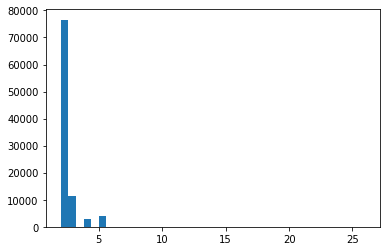

In [5]:
print("Max target len: {}".format(np.max(all_targets_len)))

import matplotlib.pyplot as plt
n, bins, patches = plt.hist(all_targets_len, 40)
plt.show()